In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import linear_model
%matplotlib inline

### A. Data Cleaning

In [2]:
# Open the FBI's 2013 New York crime dataset (skip first four rows).
df_ny13 = pd.read_csv('https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/New_York_offenses/NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013%20-%2013tbl8ny.csv', skiprows=4)
df_ny13.shape

(351, 13)

In [3]:
df_ny13.head()

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
0,Adams Village,"1,861",0,0.0,NaN,0,0,0,12,2,10,0,0.0
1,Addison Town and Village,"2,577",3,0.0,NaN,0,0,3,24,3,20,1,0.0
2,Akron Village,"2,846",3,0.0,NaN,0,0,3,16,1,15,0,0.0
3,Albany,"97,956",791,8.0,NaN,30,227,526,"4,090",705,"3,243",142,NaN
4,Albion Village,"6,388",23,0.0,NaN,3,4,16,223,53,165,5,NaN


In [4]:
# Check variable types.
df_ny13.dtypes

City                                       object
Population                                 object
Violent\ncrime                             object
Murder and\nnonnegligent\nmanslaughter    float64
Rape\n(revised\ndefinition)1              float64
Rape\n(legacy\ndefinition)2                object
Robbery                                    object
Aggravated\nassault                        object
Property\ncrime                            object
Burglary                                   object
Larceny-\ntheft                            object
Motor\nvehicle\ntheft                      object
Arson3                                    float64
dtype: object

In [5]:
# Rename columns.
df_ny13.rename(columns={'City': 'city','Population': 'population', 'Violent\ncrime': 'violent_crime', 'Murder and\nnonnegligent\nmanslaughter': 'murder', 'Rape\n(legacy\ndefinition)2': 'rape','Robbery': 'robbery', 'Aggravated\nassault': 'aggravated_assault', 'Property\ncrime': 'property_crime', 'Burglary': 'burglary', 'Larceny-\ntheft': 'larceny_theft', 'Motor\nvehicle\ntheft': 'motor_vehicle_theft', 'Arson3': 'arson'}, inplace=True)

# Create subset.
df_ny13_ppmr = df_ny13[['population', 'murder', 'robbery', 'property_crime']]

# Return the rows with null values.
df_ny13_ppmr[df_ny13_ppmr.isnull().any(axis=1)]

,population,murder,robbery,property_crime
348,NaN,NaN,NaN,NaN
349,NaN,NaN,NaN,NaN
350,NaN,NaN,NaN,NaN


In [6]:
# Drop the null values.
df_ny13_ppmr = df_ny13_ppmr.dropna()
df_ny13_ppmr.shape

(348, 4)

In [7]:
# Create function to remove commas and convert columns to numeric.
cols_ppmr = df_ny13_ppmr.columns[df_ny13_ppmr.dtypes.eq('object')]
convert_col = lambda col_obj: pd.to_numeric(col_obj.replace(',',''))
df_ny13_ppmr[cols_ppmr] = df_ny13_ppmr[cols_ppmr].applymap(convert_col)

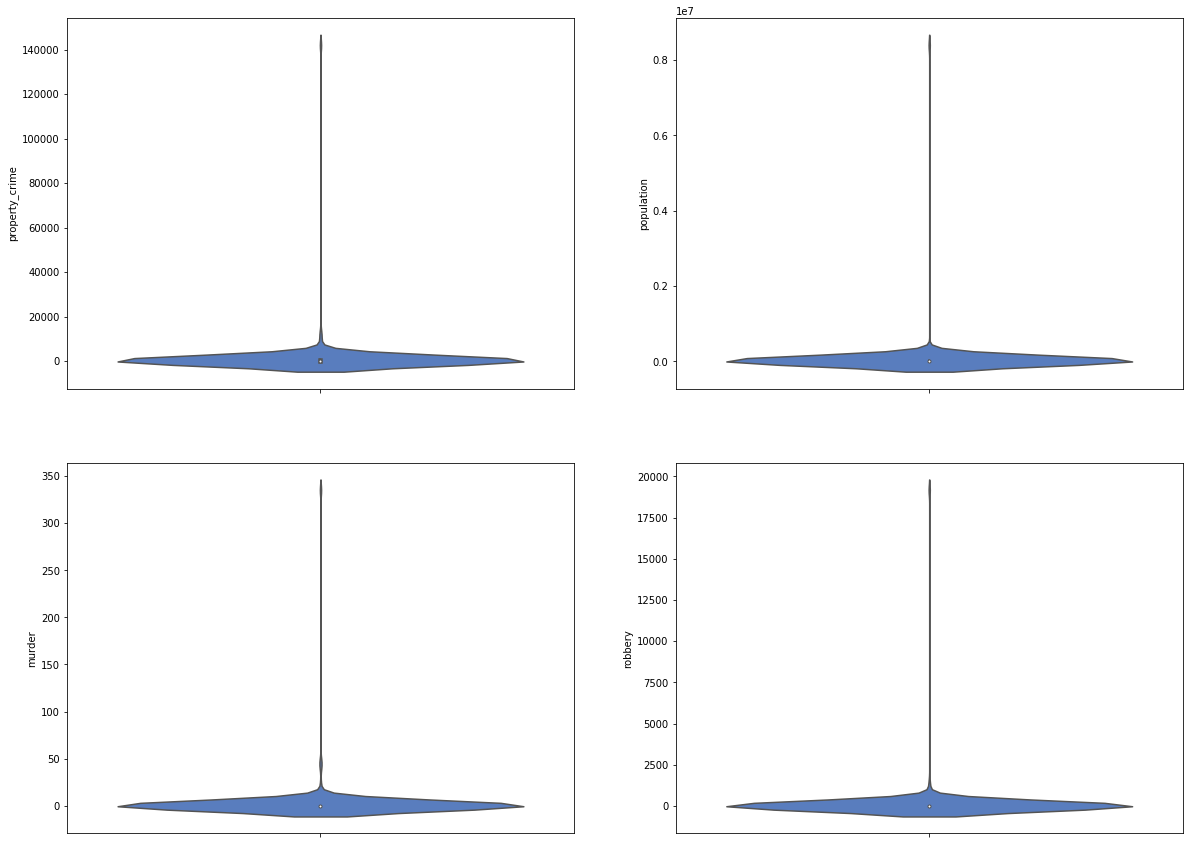

In [8]:
# Check for outliers.
fig = plt.figure(figsize=(20, 15))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

sns.violinplot(y='property_crime', palette='muted', data=df_ny13_ppmr, ax=ax1)
sns.violinplot(y='population', palette='muted', data=df_ny13_ppmr, ax=ax2)
sns.violinplot(y='murder', palette='muted', data=df_ny13_ppmr, ax=ax3)
sns.violinplot(y='robbery', palette='muted', data=df_ny13_ppmr, ax=ax4)
plt.show()

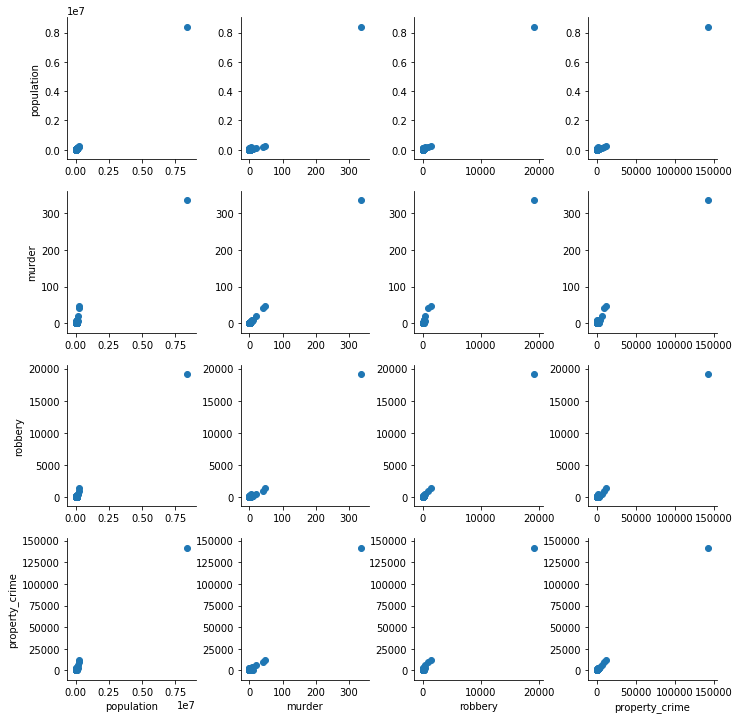

In [9]:
g = sns.PairGrid(df_ny13_ppmr)
g = g.map(plt.scatter)

In [10]:
# Show top outliers.
print(df_ny13_ppmr['property_crime'].sort_values(ascending=False).head(10))
print('\n')
print(df_ny13_ppmr['population'].sort_values(ascending=False).head(10))
print('\n')
print(df_ny13_ppmr['murder'].sort_values(ascending=False).head(10))
print('\n')
print(df_ny13_ppmr['robbery'].sort_values(ascending=False).head(10))

216    141971
35      12491
272     10051
310      6473
3        4090
218      2807
285      2800
53       2689
321      2528
346      2368
Name: property_crime, dtype: int64


216    8396126
35      258789
272     210562
346     199134
310     143834
7       118296
3        97956
126      96667
267      87204
57       80705
Name: population, dtype: int64


216    335.0
35      47.0
272     42.0
310     21.0
140     10.0
3        8.0
285      8.0
321      7.0
262      7.0
346      6.0
Name: murder, dtype: float64


216    19170
35      1322
272      918
310      400
346      390
206      228
3        227
140      204
285      203
218      166
Name: robbery, dtype: int64


In [11]:
# Create features.
df_ny13_ppmr['population_squared'] = df_ny13_ppmr['population'] * df_ny13_ppmr['population']
df_ny13_ppmr['murder_category'] = np.where(df_ny13_ppmr['murder']>0, 1, 0)
df_ny13_ppmr['robbery_category'] = np.where(df_ny13_ppmr['robbery']>0, 1, 0)
df_ny13_ppmr.head()

,population,murder,robbery,property_crime,population_squared,murder_category,robbery_category
0,1861,0.0,0,12,3463321,0,0
1,2577,0.0,0,24,6640929,0,0
2,2846,0.0,0,16,8099716,0,0
3,97956,8.0,227,4090,9595377936,1,1
4,6388,0.0,4,223,40806544,0,1


In [12]:
# Run the regression model based on population and the three created features.
regr_ny13_ppmr = linear_model.LinearRegression()
y_ny13_ppmr = df_ny13_ppmr['property_crime']
X_ny13_ppmr = df_ny13_ppmr[['population','population_squared','murder_category','robbery_category']]
regr_ny13_ppmr.fit(X_ny13_ppmr, y_ny13_ppmr)

print('\nCoefficients: \n', regr_ny13_ppmr.coef_)
print('\nIntercept: \n', regr_ny13_ppmr.intercept_)
print('\nR-squared:')
print(regr_ny13_ppmr.score(X_ny13_ppmr, y_ny13_ppmr))


Coefficients: 
 [  3.46570268e-02  -2.11108019e-09   1.51866535e+01  -9.62774363e+01]

Intercept: 
 -109.575335623

R-squared:
0.996124710499


R-squared is extremely high; the model is probably overfit. Check if the regression assumptions are true. 

### B. Verify assumptions

#### 1. Multivariate non-normality

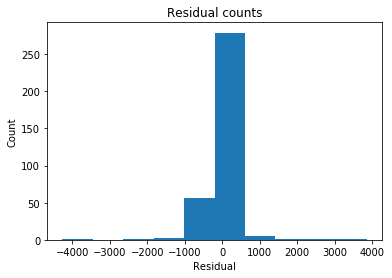

In [13]:
# Check for multivariate non-normality.
predicted_ny13_ppmr = regr_ny13_ppmr.predict(X_ny13_ppmr)
actual_ny13_ppmr = df_ny13_ppmr['property_crime']
residual_ny13_ppmr = actual_ny13_ppmr - predicted_ny13_ppmr
plt.hist(residual_ny13_ppmr)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

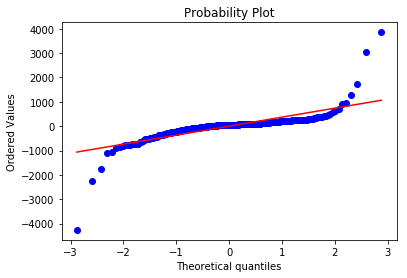

In [14]:
# Confirm with QQ plot.
import pylab 
import scipy.stats as stats

stats.probplot(residual_ny13_ppmr, plot=pylab)
plt.show()

The residuals are not normally distributed. Fix with non-linear transformations in either dependent or independent variables, or both. 

In [15]:
# Transformation causes error. Check for zeroes in property_crime (dependent variable).
df_ny13_ppmr[df_ny13_ppmr['property_crime'] == 0]

,population,murder,robbery,property_crime,population_squared,murder_category,robbery_category
186,1688,0.0,0,0,2849344,0,0
208,1622,0.0,0,0,2630884,0,0
256,1274,0.0,0,0,1623076,0,0
287,872,0.0,0,0,760384,0,0
295,1437,0.0,0,0,2064969,0,0
319,615,0.0,0,0,378225,0,0


In [16]:
# Drop rows with zeroes.
df_ny13_ppmr_nzpc = df_ny13_ppmr[df_ny13_ppmr['property_crime'] != 0]
df_ny13_ppmr_nzpc.shape

(342, 7)

Removing rows with zeroes in the dependent variable should not adversely impact the model since they don't add to the model's predictive value. The same can't be said for independent variables. Rows with zero independent variables will not be dropped, therefore, transformation will be limited to the dependent variable. Log transformation will be conducted since it is best suited for dealing with outliers, which causes residual non-normality. 

In [17]:
# Rerun the model with log transformation on the dependent variable.
regr_ny13_ppmr_nzpc = linear_model.LinearRegression()
y_ny13_ppmr_nzpc = np.log(df_ny13_ppmr_nzpc['property_crime'])
X_ny13_ppmr_nzpc = df_ny13_ppmr_nzpc[['population','population_squared','murder_category','robbery_category']]
regr_ny13_ppmr_nzpc.fit(X_ny13_ppmr_nzpc, y_ny13_ppmr_nzpc)

print('\nCoefficients: \n', regr_ny13_ppmr_nzpc.coef_)
print('\nIntercept: \n', regr_ny13_ppmr_nzpc.intercept_)
print('\nR-squared:')
print(regr_ny13_ppmr_nzpc.score(X_ny13_ppmr_nzpc, y_ny13_ppmr_nzpc))


Coefficients: 
 [  2.53312085e-05  -2.92565093e-12   4.94593986e-01   1.63131662e+00]

Intercept: 
 3.29309526531

R-squared:
0.690682085308


The model's accuracy dropped significantly. 

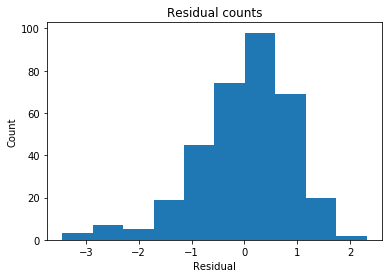

In [18]:
# Verify residual distribution.
predicted_ny13_ppmr_nzpc = regr_ny13_ppmr_nzpc.predict(X_ny13_ppmr_nzpc)
actual_ny13_ppmr_nzpc = y_ny13_ppmr_nzpc
residual_ny13_ppmr_nzpc = actual_ny13_ppmr_nzpc - predicted_ny13_ppmr_nzpc
plt.hist(residual_ny13_ppmr_nzpc)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

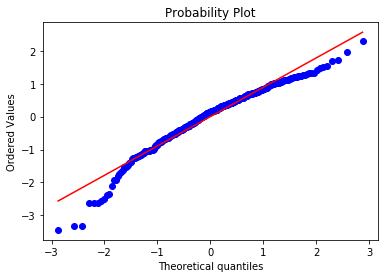

In [19]:
# Check with QQ plot.
stats.probplot(residual_ny13_ppmr_nzpc, plot=pylab)
plt.show()

The log transformation appears to have improved the residual distribution, but at the expense of model accuracy. 

##### a. Comparison: Outliers removed

In [20]:
# Compare results with data where outliers are removed.
df_ny13_ppmr_or = df_ny13_ppmr[df_ny13_ppmr['population']<100000]

In [21]:
regr_ny13_ppmr_or = linear_model.LinearRegression()
y_ny13_ppmr_or = df_ny13_ppmr_or['property_crime']
X_ny13_ppmr_or = df_ny13_ppmr_or[['population','population_squared','murder_category','robbery_category']]
regr_ny13_ppmr_or.fit(X_ny13_ppmr_or, y_ny13_ppmr_or)

print('\nCoefficients: \n', regr_ny13_ppmr_or.coef_)
print('\nIntercept: \n', regr_ny13_ppmr_or.intercept_)
print('\nR-squared:')
print(regr_ny13_ppmr_or.score(X_ny13_ppmr_or, y_ny13_ppmr_or))


Coefficients: 
 [  1.31899277e-02   1.36183482e-07   1.94770525e+02   8.05675060e+01]

Intercept: 
 -18.823557926

R-squared:
0.745964704737


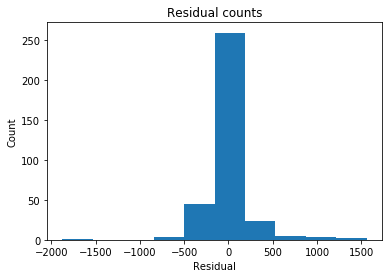

In [22]:
predicted_ny13_ppmr_or = regr_ny13_ppmr_or.predict(X_ny13_ppmr_or)
actual_ny13_ppmr_or = y_ny13_ppmr_or
residual_ny13_ppmr_or = actual_ny13_ppmr_or - predicted_ny13_ppmr_or
plt.hist(residual_ny13_ppmr_or)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

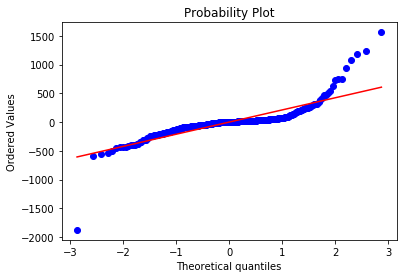

In [23]:
stats.probplot(residual_ny13_ppmr_or, plot=pylab)
plt.show()

##### b. Comparison: Outliers removed with log transformation

In [24]:
regr_ny13_ppmr_orlt = linear_model.LinearRegression()
df_ny13_ppmr_orlt = df_ny13_ppmr_nzpc[df_ny13_ppmr_nzpc['population']<100000]
y_ny13_ppmr_orlt = np.log(df_ny13_ppmr_orlt['property_crime'])
X_ny13_ppmr_orlt = df_ny13_ppmr_orlt[['population','population_squared','murder_category','robbery_category']]
regr_ny13_ppmr_orlt.fit(X_ny13_ppmr_orlt, y_ny13_ppmr_orlt)

print('\nCoefficients: \n', regr_ny13_ppmr_orlt.coef_)
print('\nIntercept: \n', regr_ny13_ppmr_orlt.intercept_)
print('\nR-squared:')
print(regr_ny13_ppmr_orlt.score(X_ny13_ppmr_orlt, y_ny13_ppmr_orlt))


Coefficients: 
 [  9.63342242e-05  -6.95527515e-10   1.42060833e-01   1.16510150e+00]

Intercept: 
 2.9921533517

R-squared:
0.732091721047


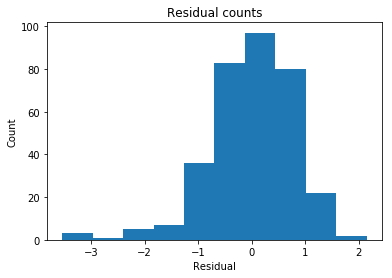

In [25]:
predicted_ny13_ppmr_orlt = regr_ny13_ppmr_orlt.predict(X_ny13_ppmr_orlt)
actual_ny13_ppmr_orlt = y_ny13_ppmr_orlt
residual_ny13_ppmr_orlt = actual_ny13_ppmr_orlt - predicted_ny13_ppmr_orlt
plt.hist(residual_ny13_ppmr_orlt)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

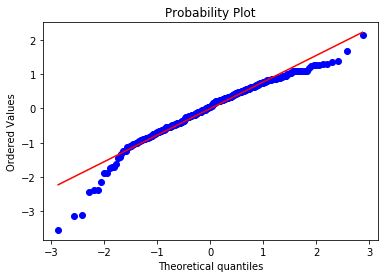

In [26]:
stats.probplot(residual_ny13_ppmr_orlt, plot=pylab)
plt.show()

The log transformation of the dependent variable where the outliers have been removed appears to improve residual distribution the most. It also improves the model's accuracy.

#### 2. Heteroscedasticity

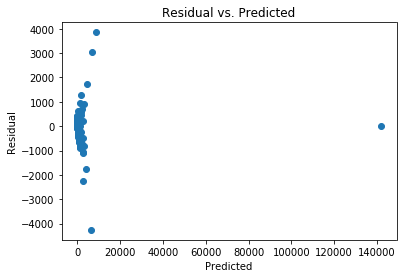

In [27]:
# Check for heteroscedasticity.
plt.scatter(predicted_ny13_ppmr, residual_ny13_ppmr)
plt.title('Residual vs. Predicted')
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.show()

Variable transformation can also address heteroscedasticity issues. The following plots show the corresponding effects.

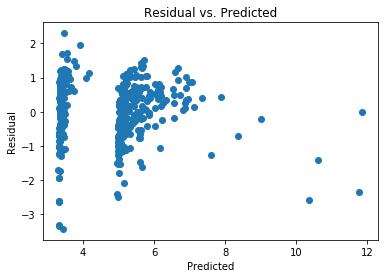

In [28]:
# Log transformation with outliers.
plt.scatter(predicted_ny13_ppmr_nzpc, residual_ny13_ppmr_nzpc)
plt.title('Residual vs. Predicted')
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.show()

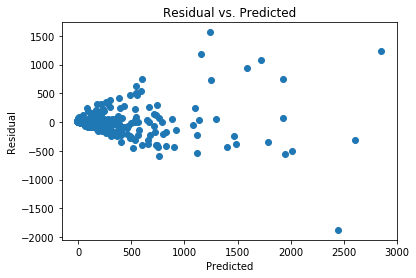

In [29]:
# Outliers removed, no transformation.
plt.scatter(predicted_ny13_ppmr_or, residual_ny13_ppmr_or)
plt.title('Residual vs. Predicted')
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.show()

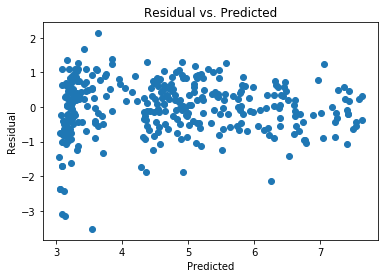

In [30]:
# Outliers removed, with transformation.
plt.scatter(predicted_ny13_ppmr_orlt, residual_ny13_ppmr_orlt)
plt.title('Residual vs. Predicted')
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.show()

As with multivariate non-normality, log transformation on the dependent variable where the outliers have been removed appear to have the most effect on heteroscedasticity.

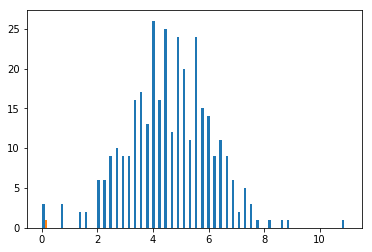

In [31]:
# Another option for heteroscedasticity is the boxcox transformation.
from scipy.stats import boxcox
y_bc_ny13 = boxcox(df_ny13_ppmr_nzpc['property_crime'])
plt.hist(y_bc_ny13, bins=50)
plt.show()

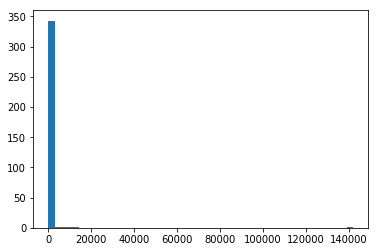

In [32]:
# For comparison, a plot of the original dependent variable is shown.
plt.hist(y_ny13_ppmr, bins=50)
plt.show()

### C. Build a model

#### 1. Preset features

Use the features created earlier - square of population and categorical representation of murder and robbery.

In [33]:
# Use statsmodels (as opposed to scikit-learn) for summary table.
import statsmodels.formula.api as smf

# Fit the model on the features that were created earlier for population, murder and robbery.
rc_ny13_ppmr = smf.ols(formula='property_crime ~ population + population_squared + murder_category + robbery_category', data=df_ny13_ppmr_orlt).fit()

# Print the summary table.
rc_ny13_ppmr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         property_crime   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     240.9
Date:                Sun, 07 Jan 2018   Prob (F-statistic):           1.14e-96
Time:                        20:54:12   Log-Likelihood:                -2333.3
No. Observations:                 336   AIC:                             4677.
Df Residuals:                     331   BIC:                             4696.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            -18.9381     24.356     -0.778      0.437     -66.850      28.974
population             0.0132      0.003      5.188      0.000       0.008       0.018
population_squared  1.361e-07   3.15e-08      4.322      0.000    7.42e-08    1.98e-07
murder_category      194.7452     47.549      4.096      0.000     101.210     288.281
robbery_category      80.6318     33.525      2.405      0.017      14.683     146.580
==============================================================================
Omnibus:                      114.955   Durbin-Watson:                   1.928
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4206.557
Skew:                           0.657   Prob(JB):                         0.00
Kurtosis:                      20.284   Cond. No.                     4.53e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.53e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

All features have significant p values (< 0.05), which means the null hypothesis, i.e., that there is no association between these features and property crime can be rejected. These features are therefore valid and can be kept in this model, which has a modest accuracy at 0.74 R-squared.

In [34]:
# Predict and compare with actual.
print('Predicted:')
print(rc_ny13_ppmr.predict(X_ny13_ppmr_orlt).head())
print('\n')
print('Actual:')
print(df_ny13_ppmr_orlt['property_crime'].head())

Predicted:
0       6.088937
1      15.969010
2      19.717006
3    2855.158447
4     151.537257
dtype: float64


Actual:
0      12
1      24
2      16
3    4090
4     223
Name: property_crime, dtype: int64


#### 2. Feature selection

Select variables using automatic feature selection techniques. For demonstration purposes, two techniques will be used. The entire dataset will be utilized and prepared per the steps below.

In [35]:
# Show null count for each column.
df_ny13.isnull().sum()

city                              0
population                        3
violent_crime                     3
murder                            3
Rape\n(revised\ndefinition)1    351
rape                              3
robbery                           3
aggravated_assault                3
property_crime                    3
burglary                          3
larceny_theft                     3
motor_vehicle_theft               3
arson                           164
dtype: int64

In [36]:
# Check null rows.
df_ny13.tail()

,city,population,violent_crime,murder,Rape (revised definition)1,rape,robbery,aggravated_assault,property_crime,burglary,larceny_theft,motor_vehicle_theft,arson
346,Yonkers,"199,134","1,036",6.0,NaN,25,390,615,"2,368",470,"1,662",236,10.0
347,Yorktown Town,"36,643",15,0.0,NaN,0,2,13,334,45,287,2,NaN
348,1 The figures shown in this column for the off...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
349,2 The figures shown in this column for the off...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
350,3 The FBI does not publish arson data unless i...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
# Drop unnecessary variables.
df_ny13_ncr = df_ny13.drop(['city', 'Rape\n(revised\ndefinition)1'], axis=1)

# Drop last three rows with nulls.
df_ny13_ncr = df_ny13_ncr[:-3]

# Convert arson nulls to 0.
df_ny13_ncr['arson'] = df_ny13_ncr['arson'].fillna(0)

# Convert object variables to numeric.
cols_ny13_ncr = df_ny13_ncr.columns[df_ny13_ncr.dtypes.eq('object')]
df_ny13_ncr[cols_ny13_ncr] = df_ny13_ncr[cols_ny13_ncr].applymap(convert_col)

##### a. Univariate selection

The scikit-learn library provides the SelectKBest class that can be used with a suite of different statistical tests to select a specific number of features.

In [38]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

y_ny13_ncr = df_ny13_ncr['property_crime']
X_ny13_ncr = df_ny13_ncr.drop('property_crime', axis=1)
skb_ny13_ncr = SelectKBest(score_func=chi2, k=4)
fit_ny13_ncr = skb_ny13_ncr.fit(X_ny13_ncr, y_ny13_ncr)
np.set_printoptions(precision=3)
print(fit_ny13_ncr.scores_)

[  1.755e+09   1.364e+07   7.423e+04   2.160e+05   5.060e+06   8.330e+06
   2.480e+06   2.194e+07   1.573e+06   2.143e+04]


The following features have the highest scores and will be selected to build the model:

population = 1.755e+09<br>
violent_crime = 1.364e+07<br>
aggravated_assault = 8.330e+06<br>
larceny_theft = 2.194e+07<br>

In [39]:
# Fit the model with the selected features.
rc_ny13_pval = smf.ols(formula='property_crime ~ population + violent_crime + aggravated_assault + larceny_theft', data=df_ny13_ncr).fit()

# Print the summary table.
rc_ny13_pval.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         property_crime   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 9.504e+05
Date:                Sun, 07 Jan 2018   Prob (F-statistic):               0.00
Time:                        20:54:12   Log-Likelihood:                -1985.2
No. Observations:                 348   AIC:                             3980.
Df Residuals:                     343   BIC:                             4000.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             30.8124      4.717      6.532      0.000      21.534      40.090
population            -0.0050      0.000    -18.592      0.000      -0.006      -0.004
violent_crime          3.2517      0.185     17.578      0.000       2.888       3.616
aggravated_assault    -4.6277      0.325    -14.255      0.000      -5.266      -3.989
larceny_theft          1.3614      0.014     94.982      0.000       1.333       1.390
==============================================================================
Omnibus:                      343.551   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13771.495
Skew:                           4.102   Prob(JB):                         0.00
Kurtosis:                      32.706   Cond. No.                     5.43e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.43e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The R-squared is 1.0, which indicates the model is probably overfit. The data has been confimed to have multivariate non-normality, therefore, variable transformations will be necessary.

In [40]:
# Make prediction and compare with actual.
print('Predicted:')
print(rc_ny13_pval.predict(X_ny13_ncr).head())
print('\n')
print('Actual:')
print(df_ny13_ncr['property_crime'].head())

Predicted:
0      35.138718
1      41.051528
2      32.901770
3    4094.971280
4     224.313282
dtype: float64


Actual:
0      12
1      24
2      16
3    4090
4     223
Name: property_crime, dtype: int64


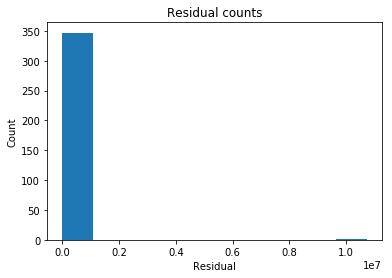

In [41]:
# Verify multivariate non-normality on the new subset.
X_ny13_pval = df_ny13_ncr[['population', 'violent_crime', 'aggravated_assault', 'larceny_theft']]
predicted_ny13_pval = regr_ny13_ppmr.predict(X_ny13_pval)
actual_ny13_pval = y_ny13_ncr
residual_ny13_pval = actual_ny13_pval - predicted_ny13_pval
plt.hist(residual_ny13_pval)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

In [42]:
# Conduct log transformation and run new coefficients and intercept.
regr_ny13_ncr_nzpc = linear_model.LinearRegression()
df_ny13_ncr_nzpc = df_ny13_ncr[df_ny13_ncr['property_crime'] != 0]
y_ny13_ncr_nzpc = np.log(df_ny13_ncr_nzpc['property_crime'])
X_ny13_ncr_nzpc = df_ny13_ncr_nzpc[['population', 'violent_crime', 'aggravated_assault', 'larceny_theft']]
regr_ny13_ncr_nzpc.fit(X_ny13_ncr_nzpc, y_ny13_ncr_nzpc)

print('\nCoefficients: \n', regr_ny13_ncr_nzpc.coef_)
print('\nIntercept: \n', regr_ny13_ncr_nzpc.intercept_)
print('\nR-squared:')
print(regr_ny13_ncr_nzpc.score(X_ny13_ncr_nzpc, y_ny13_ncr_nzpc))


Coefficients: 
 [  4.485e-06  -3.619e-03  -6.739e-03   3.172e-03]

Intercept: 
 4.12161231654

R-squared:
0.49273254556


The R-squared dropped by half after transforming the dependent variable.

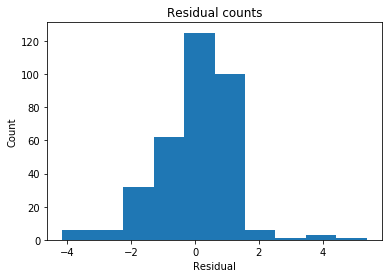

In [43]:
# Verify log transformation effect on residual.
predicted_ny13_ncr_nzpc = regr_ny13_ncr_nzpc.predict(X_ny13_ncr_nzpc)
actual_ny13_ncr_nzpc = y_ny13_ncr_nzpc
residual_ny13_ncr_nzpc = actual_ny13_ncr_nzpc - predicted_ny13_ncr_nzpc
plt.hist(residual_ny13_ncr_nzpc)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

##### b. Feature importance

Bagged decision trees like Random Forest and Extra Trees can be used to estimate the importance of features. Construct a ExtraTreesClassifier classifier for this example.

In [44]:
from sklearn.ensemble import ExtraTreesClassifier
etc = ExtraTreesClassifier()
etc.fit(X_ny13_ncr, y_ny13_ncr)
print(etc.feature_importances_)

[ 0.164  0.107  0.022  0.058  0.079  0.095  0.149  0.195  0.092  0.041]


The following features have the highest scores and will be selected to build the model: population, violent_crime, burglary, larceny_theft. The results are similar to univariate selection except for one feature.

In [45]:
# Fit the model on the selected features.
rc_ny13_pvbl = smf.ols(formula='property_crime ~ population + violent_crime + burglary + larceny_theft', data=df_ny13_ncr).fit()

# Print the summary table.
rc_ny13_pvbl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         property_crime   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.704e+07
Date:                Sun, 07 Jan 2018   Prob (F-statistic):               0.00
Time:                        20:54:13   Log-Likelihood:                -1306.3
No. Observations:                 348   AIC:                             2623.
Df Residuals:                     343   BIC:                             2642.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -1.2855      0.710     -1.812      0.071      -2.681       0.110
population        0.0002   5.54e-05      3.758      0.000    9.93e-05       0.000
violent_crime     0.1005      0.006     15.647      0.000       0.088       0.113
burglary          1.2100      0.007    163.368      0.000       1.195       1.225
larceny_theft     0.9740      0.003    280.824      0.000       0.967       0.981
==============================================================================
Omnibus:                       90.276   Durbin-Watson:                   2.134
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2296.037
Skew:                          -0.363   Prob(JB):                         0.00
Kurtosis:                      15.563   Cond. No.                     5.74e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.74e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The R-squared is also 1.0, which indicates possible overfitting.

In [46]:
# Make prediction and compare with actual.
print('Predicted:')
print(rc_ny13_pvbl.predict(X_ny13_ncr).head())
print('\n')
print('Actual:')
print(df_ny13_ncr['property_crime'].head())

Predicted:
0      11.262648
1      22.663581
2      15.429383
3    4110.453607
4     227.203506
dtype: float64


Actual:
0      12
1      24
2      16
3    4090
4     223
Name: property_crime, dtype: int64


In [47]:
# Run the log transformation and new coefficients and intercept.
regr_ny13_ncr_nzpc = linear_model.LinearRegression()
y_ny13_ncr_nzpc = np.log(df_ny13_ncr_nzpc['property_crime'])
X_ny13_ncr_nzpc = df_ny13_ncr_nzpc[['population', 'violent_crime', 'burglary', 'larceny_theft']]
regr_ny13_ncr_nzpc.fit(X_ny13_ncr_nzpc, y_ny13_ncr_nzpc)

print('\nCoefficients: \n', regr_ny13_ncr_nzpc.coef_)
print('\nIntercept: \n', regr_ny13_ncr_nzpc.intercept_)
print('\nR-squared:')
print(regr_ny13_ncr_nzpc.score(X_ny13_ncr_nzpc, y_ny13_ncr_nzpc))


Coefficients: 
 [  3.100e-05  -9.570e-03   4.631e-03   1.460e-03]

Intercept: 
 3.97704824326

R-squared:
0.536781805385


The R-squared is slightly improved compared to the univariate selection log transformation.

### D. Train and Test the Model

#### 1. Train Current Dataset

The current dataset will be trained and tested using two methods - train/test/split and K-folds cross validation.

##### a. Train/Test Split

In [48]:
# Split the data into train and test samples.
from sklearn.model_selection import train_test_split
regr_tts_ny13 = linear_model.LinearRegression()

# Use the outlier-removed dataset (dependent variable not log-transformed).
X_train_tts_ny13, X_test_tts_ny13, y_train_tts_ny13, y_test_tts_ny13 = train_test_split(X_ny13_ppmr_or, df_ny13_ppmr_or['property_crime'], test_size=0.3)

# Train the model.
lm_tts_ny13 = regr_tts_ny13.fit(X_train_tts_ny13, y_train_tts_ny13)

# Make predictions on the test sample.
predictions_tts_ny13 = regr_tts_ny13.predict(X_test_tts_ny13)

# Compare predicted vs. actual.
print('Predicted:', predictions_tts_ny13[0:5])
print('\n')
print('Actual:')
print(y_test_tts_ny13[0:5])

Predicted: [  139.931   288.261    13.189  1255.603    24.937]


Actual:
92      288
313     315
105      33
152    1353
245      41
Name: property_crime, dtype: int64


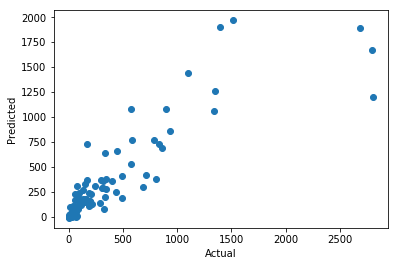

In [49]:
# Show scatterplot of predicted vs. actual.
plt.scatter(y_test_tts_ny13, predictions_tts_ny13)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [50]:
# Model score.
print('Score:', lm_tts_ny13.score(X_test_tts_ny13, y_test_tts_ny13))

Score: 0.76529873604


When the outlier-removed, log-transformed dataset is used for training and testing, as opposed to just the outlier-removed dataset, the score slightly improves.

##### b. K-Folds Cross Validation

In [51]:
# Run the default three subsets, or folds, for cross validation.
from sklearn.cross_validation import cross_val_score, cross_val_predict
scores_cv_ny13 = cross_val_score(lm_tts_ny13, X_ny13_ppmr_or, y_ny13_ppmr_or)

# The score for each fold.
print('Cross validated scores:', scores_cv_ny13)

# Mean score.
print('Average score:', scores_cv_ny13.mean())

Cross validated scores: [ 0.76   0.689  0.6  ]
Average score: 0.683226566421


C:\Users\James\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


The cross validation average score is lower than train/test/split score, but as with the latter the former's score improves when the outlier-removed, log-transformed dataset is used.

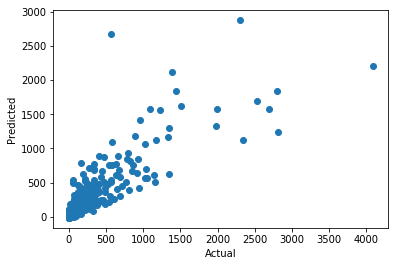

In [52]:
# Show scatterplot of predicted vs. actual.
predictions_cv_ny13 = cross_val_predict(lm_tts_ny13, X_ny13_ppmr_or, y_ny13_ppmr_or)
plt.scatter(y_ny13_ppmr_or, predictions_cv_ny13)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [53]:
# Calculate the R squared of the cross validation model (outlier-removed, not log-transformed).
from sklearn import metrics
r_squared_cv_ny13 = metrics.r2_score(y_ny13_ppmr_or, predictions_cv_ny13)
print('K-folds cross validation R-squared:', r_squared_cv_ny13)

K-folds cross validation R-squared: 0.693898656944


#### 2. Test on New Dataset

Transform the new dataset so it has similar features as the NY 2013 training data. Note that when the new dataset (i.e., test) is not similar to the training data, the model returns erroneous results.

##### a. Same state, different year

In [54]:
# Open NY 2014 data.
df_ny14 = pd.read_excel('Table_8_Offenses_Known_to_Law_Enforcement_by_New_York_by_City_2014.xls', skiprows=4)
df_ny14.dtypes

City                                       object
Population                                float64
Violent\ncrime                            float64
Murder and\nnonnegligent\nmanslaughter    float64
Rape\n(revised\ndefinition)1              float64
Rape\n(legacy\ndefinition)2               float64
Robbery                                   float64
Aggravated\nassault                       float64
Property\ncrime                           float64
Burglary                                  float64
Larceny-\ntheft                           float64
Motor\nvehicle\ntheft                     float64
Arson3                                    float64
dtype: object

In [55]:
# Rename applicable columns.
df_ny14.rename(columns={'Population': 'population', 'Murder and\nnonnegligent\nmanslaughter': 'murder', 'Robbery': 'robbery', 'Property\ncrime': 'property_crime'}, inplace=True)
df_ny14_ppmr = df_ny14[['population', 'murder', 'robbery', 'property_crime']]

# Show null count.
df_ny14_ppmr.isnull().sum()

population        7
murder            7
robbery           7
property_crime    8
dtype: int64

In [56]:
# Remove null rows.
df_ny14_ppmr = df_ny14_ppmr[:-7].fillna(0)

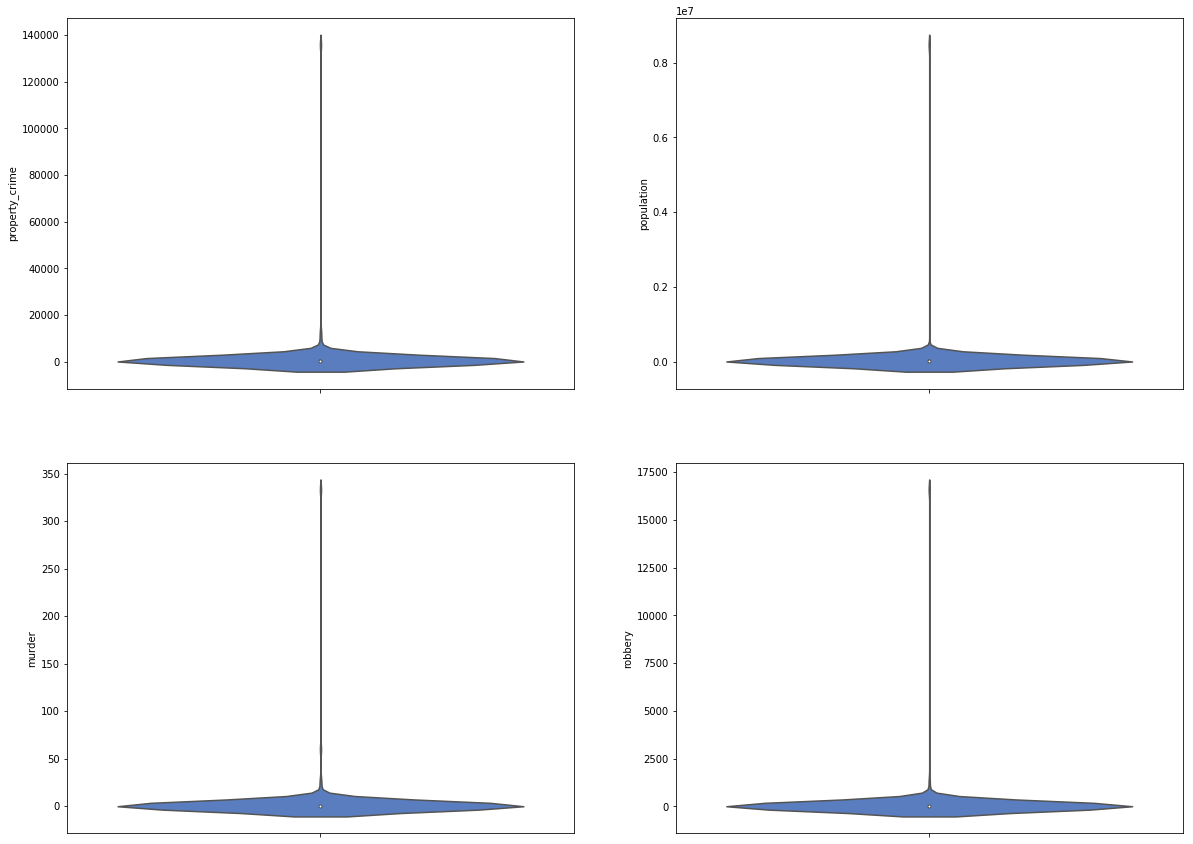

In [57]:
# Check for outliers.
fig = plt.figure(figsize=(20, 15))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

sns.violinplot(y='property_crime', palette='muted', data=df_ny14_ppmr, ax=ax1)
sns.violinplot(y='population', palette='muted', data=df_ny14_ppmr, ax=ax2)
sns.violinplot(y='murder', palette='muted', data=df_ny14_ppmr, ax=ax3)
sns.violinplot(y='robbery', palette='muted', data=df_ny14_ppmr, ax=ax4)
plt.show()

In [58]:
# Show top outliers.
print(df_ny14_ppmr['property_crime'].sort_values(ascending=False).head(10))
print('\n')
print(df_ny14_ppmr['population'].sort_values(ascending=False).head(10))
print('\n')
print(df_ny14_ppmr['murder'].sort_values(ascending=False).head(10))
print('\n')
print(df_ny14_ppmr['robbery'].sort_values(ascending=False).head(10))

227    135747.0
38      12449.0
283      8856.0
326      5755.0
4        3888.0
57       2699.0
229      2641.0
299      2518.0
130      2430.0
338      2366.0
Name: property_crime, dtype: float64


227    8473938.0
38      258419.0
283     210347.0
366     200624.0
326     144534.0
9       118860.0
4        98595.0
130      97144.0
279      88881.0
62       81435.0
Name: population, dtype: float64


227    333.0
38      60.0
283     27.0
326     20.0
4        8.0
147      8.0
331      7.0
338      6.0
218      6.0
299      5.0
Name: murder, dtype: float64


227    16581.0
38      1277.0
283      698.0
326      406.0
366      358.0
147      248.0
4        237.0
218      195.0
229      161.0
299      158.0
Name: robbery, dtype: float64


In [59]:
# Remove outliers.
df_ny14_ppmr_or = df_ny14_ppmr[df_ny14_ppmr['population']<100000]

In [60]:
# Create the same features as NY 2013 and create the NY 2014 dataframe based on these features.
df_ny14_ppmr_or['population_squared'] = df_ny14_ppmr_or['population'] * df_ny14_ppmr_or['population']
df_ny14_ppmr_or['murder_category'] = np.where(df_ny14_ppmr_or['murder']>0, 1, 0)
df_ny14_ppmr_or['robbery_category'] = np.where(df_ny14_ppmr_or['robbery']>0, 1, 0)
X_ny14_ppmr_or = df_ny14_ppmr_or[['population','population_squared', 'murder_category', 'robbery_category']]
y_ny14_ppmr_or = df_ny14_ppmr_or['property_crime']

C:\Users\James\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\James\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\James\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [61]:
# Test the NY 2013 train/test/split model on NY 2014 data.
predictions_ny14_ppmr_or = regr_tts_ny13.predict(X_ny14_ppmr_or)

# Show the predicted vs. actual values.
print('Predicted:', predictions_ny14_ppmr_or[0:5])
print('\n')
print('Actual:')
print(y_ny14_ppmr_or[0:5])

Predicted: [    3.808   105.56     -9.225    16.614  2816.345]


Actual:
0      11.0
1      49.0
2       1.0
3      17.0
4    3888.0
Name: property_crime, dtype: float64


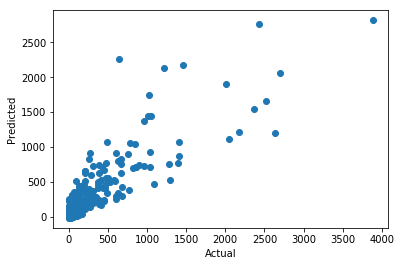

In [62]:
# Plot the comparison.
plt.scatter(y_ny14_ppmr_or, predictions_ny14_ppmr_or)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [63]:
# The NY 2013 model's score on NY 2014 data. 
print('Score:', lm_tts_ny13.score(X_ny14_ppmr_or, y_ny14_ppmr_or))

Score: 0.742305365309


The NY 2014 score is lower compared to the NY 2013 model tested on itself.

In [64]:
# Cross validate NY 2014 data with NY 2013 model.
scores_cv_ny14 = cross_val_score(lm_tts_ny13, X_ny14_ppmr_or, y_ny14_ppmr_or)

# The score for each fold.
print('Cross validated scores:', scores_cv_ny14)

# Mean score.
print('Average score:', scores_cv_ny14.mean())

Cross validated scores: [ 0.778  0.671  0.632]
Average score: 0.693585705025


The NY 2014 average score is slightly higher compared to the NY 2013 model cross validated on itself, but still lower compared to the train/test/split score.

##### b. Different state, same year

In [65]:
# Open AL 2013 data.
df_al13 = pd.read_excel('table_8_offenses_known_to_law_enforcement_alabama_by_city_2013.xls', skiprows=4)
df_al13.dtypes

City                                       object
Population                                float64
Violent\ncrime                            float64
Murder and\nnonnegligent\nmanslaughter    float64
Rape\n(revised\ndefinition)1              float64
Rape\n(legacy\ndefinition)2               float64
Robbery                                   float64
Aggravated\nassault                       float64
Property\ncrime                           float64
Burglary                                  float64
Larceny-\ntheft                           float64
Motor\nvehicle\ntheft                     float64
Arson3                                    float64
Unnamed: 13                               float64
Unnamed: 14                               float64
Unnamed: 15                                object
dtype: object

In [66]:
# Rename applicable columns.
df_al13.rename(columns={'Population': 'population', 'Murder and\nnonnegligent\nmanslaughter': 'murder', 'Robbery': 'robbery', 'Property\ncrime': 'property_crime'}, inplace=True)
df_al13_ppmr = df_al13[['population', 'murder', 'robbery', 'property_crime']]

# Show null count.
df_al13_ppmr.isnull().sum()

population        5
murder            5
robbery           5
property_crime    5
dtype: int64

In [67]:
# Remove null rows.
df_al13_ppmr = df_al13_ppmr[:-5]

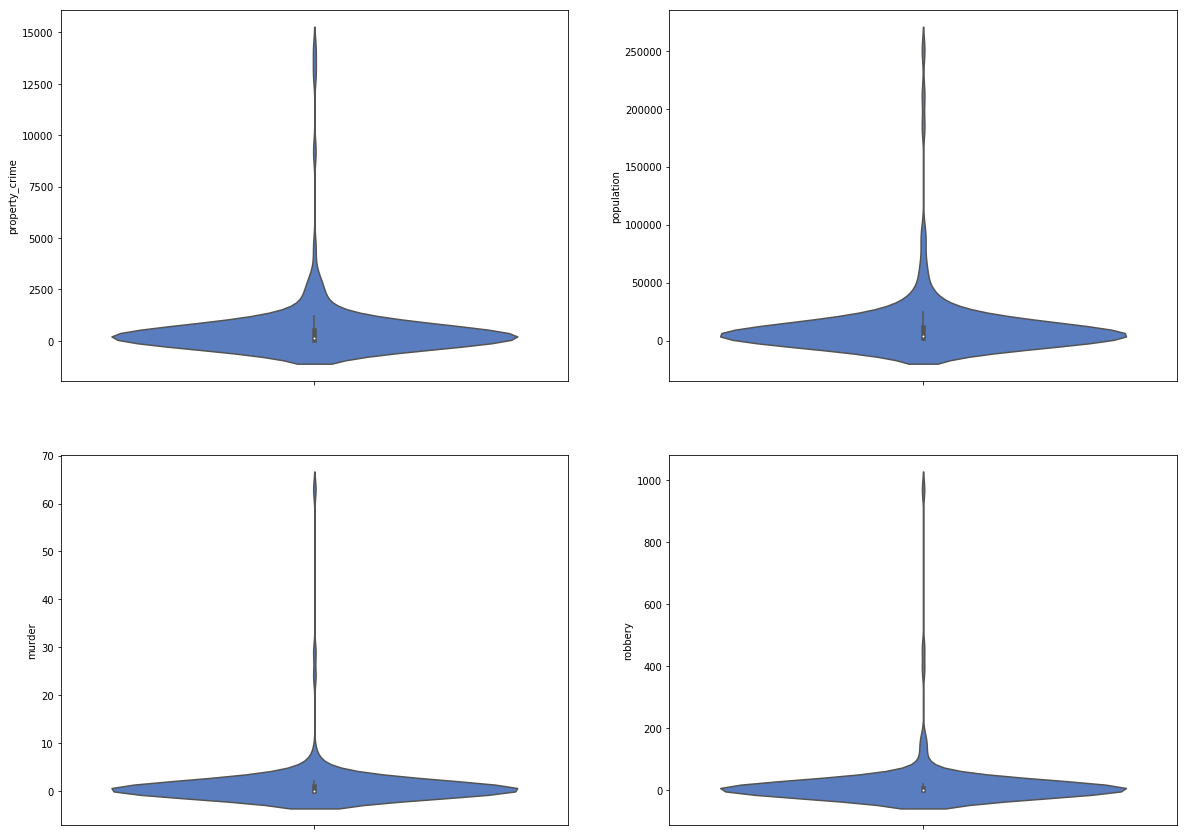

In [68]:
# Check for outliers.
fig = plt.figure(figsize=(20, 15))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

sns.violinplot(y='property_crime', palette='muted', data=df_al13_ppmr, ax=ax1)
sns.violinplot(y='population', palette='muted', data=df_al13_ppmr, ax=ax2)
sns.violinplot(y='murder', palette='muted', data=df_al13_ppmr, ax=ax3)
sns.violinplot(y='robbery', palette='muted', data=df_al13_ppmr, ax=ax4)
plt.show()

In [69]:
# Show top outliers.
print(df_al13_ppmr['property_crime'].sort_values(ascending=False).head(10))
print('\n')
print(df_al13_ppmr['population'].sort_values(ascending=False).head(10))
print('\n')
print(df_al13_ppmr['murder'].sort_values(ascending=False).head(10))
print('\n')
print(df_al13_ppmr['robbery'].sort_values(ascending=False).head(10))

20     14157.0
117    13011.0
90      9216.0
182     4512.0
19      3199.0
68      2934.0
88      2596.0
47      2553.0
50      2502.0
141     2404.0
Name: property_crime, dtype: float64


117    250557.0
20     212001.0
90     184738.0
182     94126.0
88      84139.0
50      67811.0
16      57970.0
47      56091.0
110     45540.0
65      39481.0
Name: population, dtype: float64


20     63.0
117    29.0
90     24.0
182     8.0
68      6.0
141     5.0
47      5.0
7       5.0
148     4.0
50      4.0
Name: murder, dtype: float64


20     969.0
117    459.0
90     391.0
182    161.0
19     161.0
148    134.0
68     104.0
7       78.0
50      78.0
60      67.0
Name: robbery, dtype: float64


In [70]:
# Remove outliers.
df_al13_ppmr_or = df_al13_ppmr[df_al13_ppmr['population']<100000]

In [71]:
# Create the same features as NY 2013 and create the AL 2013 dataframe based on these features.
df_al13_ppmr_or['population_squared'] = df_al13_ppmr_or['population'] * df_al13_ppmr_or['population']
df_al13_ppmr_or['murder_category'] = np.where(df_al13_ppmr_or['murder']>0, 1, 0)
df_al13_ppmr_or['robbery_category'] = np.where(df_al13_ppmr_or['robbery']>0, 1, 0)
X_al13_ppmr_or = df_al13_ppmr_or[['population','population_squared', 'murder_category', 'robbery_category']]
y_al13_ppmr_or = df_al13_ppmr_or['property_crime']

C:\Users\James\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\James\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\James\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [72]:
# Test the NY 2013 train/test/split model on AL 2013 data.
predictions_al13_ppmr_or = regr_tts_ny13.predict(X_al13_ppmr_or)

# Show the predicted vs. actual values.
print('Predicted:', predictions_al13_ppmr_or[0:5])
print('\n')
print('Actual:')
print(y_al13_ppmr_or[0:5])

Predicted: [ 288.118  312.465  -10.174  590.705  464.98 ]


Actual:
0     63.0
1    321.0
2     25.0
3    640.0
4    661.0
Name: property_crime, dtype: float64


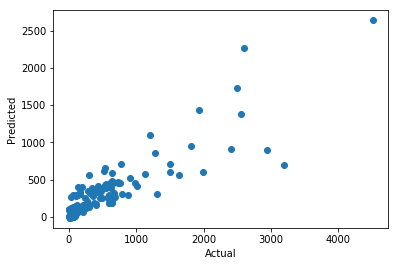

In [73]:
# Plot the comparison.
plt.scatter(y_al13_ppmr_or, predictions_al13_ppmr_or)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [74]:
# The NY 2013 model's score on AL 2013 data. 
print('Score:', lm_tts_ny13.score(X_al13_ppmr_or, y_al13_ppmr_or))

Score: 0.624031093352


The AL 2013 score is much lower than the NY 2014 and 2013 scores.

In [75]:
# Cross validate AL 2013 data with NY 2013 model.
scores_cv_al13 = cross_val_score(lm_tts_ny13, X_al13_ppmr_or, y_al13_ppmr_or)

# The score for each fold.
print('Cross validated scores:', scores_cv_al13)

# Mean score.
print('Average score:', scores_cv_al13.mean())

Cross validated scores: [ 0.768  0.713  0.811]
Average score: 0.763813008499


A summary of the NY 2013 model test scores is shown below:

Score|NY 2013|NY 2014|AL 2013
-----|-------|-------|-------
TTS  |  0.765|  0.742|  0.624
CV   |  0.683|  0.694|  0.764